In [1]:
import numpy as np
#for plots as png
# %matplotlib inline
#for animation
# %matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from geopy.distance import geodesic
import json
import pandas as pd
import random

In [2]:
path = './city/city.csv'
df = pd.read_csv(path, sep=',')
df = df[['city', 'city_type', 'geo_lat', 'geo_lon', 'population']]
df = df[df['city_type'] == 'г']
df = df[['city', 'geo_lon', 'geo_lat', 'population']]
df.head()

,city,geo_lon,geo_lat,population
0,Адыгейск,39.190289,44.878414,12689
1,Майкоп,40.100661,44.609827,144055
2,Горно-Алтайск,85.960324,51.958103,62861
3,Алейск,82.779361,52.492251,28528
4,Барнаул,83.779806,53.347997,635585


In [3]:
with open('./russia.json') as f:
    data = json.load(f)[0]
    bbox = data['boundingbox']
    coordinates = [coords[0] for coords in data['geojson']['coordinates']]

In [4]:
largest_cities = df[df.index.isin(df['population'].nlargest(30).index)]
largest_cities

,city,geo_lon,geo_lat,population
4,Барнаул,83.779806,53.347997,635585
62,Уфа,55.957847,54.734944,1062300
121,Волгоград,44.517034,48.707004,1021244
159,Воронеж,39.196923,51.659333,889680
177,Махачкала,47.504718,42.984916,577990
223,Иркутск,104.280747,52.286404,587225
316,Кемерово,86.046778,55.391065,532884
322,Новокузнецк,87.214275,53.794315,547885
381,Краснодар,38.975965,45.040160,744933
411,Красноярск,92.852481,56.009388,973826


In [5]:
class SA:
    def __init__(self, temp: float, gamma: float, cities: pd.DataFrame, iterations: int = 100, temp_limit: float | None = None):
        self.iterations = iterations
        self.temp_limit = temp_limit
        self.temp = temp
        self.cities = cities
        self.cities['order'] = list(range(len(self.cities)))
        self.gamma = gamma
        self.distance = self.whole_distance(self.cities)
    @staticmethod
    def whole_distance(cities: pd.DataFrame):
        cities = cities.sort_values(by='order')
        total_distance = 0
        for index, row in cities.iterrows():
            if row['order'] != 0:
                total_distance += SA.distance_between_points(row['geo_lon'], row['geo_lat'], last_row['geo_lon'], last_row['geo_lat'])
            last_row = row
        return total_distance
    def cool_temp(self):
        self.temp = self.gamma * self.temp
    def check_accept(self, new_solution: float, current_solution: float):
        # alpha = min(1, np.exp(-(new_solution - current_solution) / self.temp))
        alpha = np.exp(-(new_solution - current_solution) / self.temp)
        if alpha >= random.uniform(0, 1):
            return True
        else:
            return False
    @staticmethod
    def distance_between_points(lon1: float, lat1: float, lon2: float, lat2: float):
        return geodesic((lat1, lon1), (lat2, lon2)).kilometers
    def swap_elements(self):
        cities = self.cities.copy()
        swap_list_indx = list(range(len(cities)))
        i = random.randint(swap_list_indx[0], swap_list_indx[-1])
        j = i
        while i == j:
            j = random.randint(swap_list_indx[0], swap_list_indx[-1])
        order_i = cities.loc[cities['order'] == i, 'order'].tolist()[0]
        order_j = cities.loc[cities['order'] == j, 'order'].tolist()[0]
        def swap(x):
            if x == order_i:
                return order_j
            if x == order_j:
                return order_i
            return x
        cities['order'] = cities['order'].apply(swap)
        return cities

    def make_animation(self, interval: int = 100):
        fig, ax = plt.subplots(figsize = (50, 25))
        def init(step: int | None = None, t: float | None = None, distance: float | None = None):
            #scatter all cities as points
            ax.scatter(self.cities['geo_lon'], self.cities['geo_lat'], c='b', s=100)
            xs = [coord[0] for polygon in coordinates for coord in polygon]
            ys = [coord[1] for polygon in coordinates for coord in polygon]
            #draw Russian border
            ax.scatter(xs, ys, zorder=1, c='r', s=10)
            if step and t and distance:
                ax.set_title(f'Russia (step {step}, T={t}, d={distance})')
            else:
                ax.set_title('Russia')
            #there are no cities from Kaliningradskaya oblast and Crimea in the top 30 largest cities, so map can be cut
            ax.set_xlim([20, 180])
            ax.set_xlabel('longitude', fontsize=18)
            ax.set_ylabel('latitude', fontsize=16)

        def animate(step: int):
            self.step()
            ax.clear()

            if self.temp_limit and self.temp <= self.temp_limit:
                ax.text(0.5, 0.5, 'Animation is ended')
                return
            init(step, self.temp, self.distance)
            self.cities = self.cities.sort_values(by='order')
            for index, row in self.cities.iterrows():
                if row['order'] != 0:
                    x, y = row['geo_lon'], row['geo_lat']
                    dx, dy = last_row['geo_lon'] - x, last_row['geo_lat'] - y
                    ax.arrow(x, y, dx, dy, length_includes_head=True, head_width=1, width=0.01)
                last_row = row
        anim = animation.FuncAnimation(fig, animate, frames=self.iterations, init_func=init, interval=interval)
        return anim

    def plot_map(self):
        fig, ax = plt.subplots(figsize = (10, 5))
        #scatter all cities as points
        ax.scatter(self.cities['geo_lon'], self.cities['geo_lat'], c='b', s=20)
        xs = [coord[0] for polygon in coordinates for coord in polygon]
        ys = [coord[1] for polygon in coordinates for coord in polygon]
        #draw Russian border
        ax.scatter(xs, ys, zorder=1, c='r', s=5)

        self.cities = self.cities.sort_values(by='order')
        for index, row in self.cities.iterrows():
            if row['order'] != 0:
                x, y = row['geo_lon'], row['geo_lat']
                dx, dy = last_row['geo_lon'] - x, last_row['geo_lat'] - y
                # ax.plot([row['geo_lon'], last_row['geo_lon']], [row['geo_lat'], last_row['geo_lat']], color='k')
                ax.arrow(x, y, dx, dy, length_includes_head=True, head_width=1)
            last_row = row
        ax.set_title('Russia')
        #there are no cities in Kaliningradskaya oblast and Crimea in the top 30 largest cities, so map can be cut
        ax.set_xlim([20, 180])
        ax.set_xlabel('longitude', fontsize=18)
        ax.set_ylabel('latitude', fontsize=16)
        plt.show()
    def step(self):
        # swap cities
        cities_new = self.swap_elements()
        # calculate new distance
        distance_new = self.whole_distance(cities_new)
        if self.check_accept(distance_new, self.distance):
            self.cities = cities_new
            self.distance = distance_new
        # update temperature
        self.cool_temp()
    def annealing(self):
        best = []
        if self.temp_limit:
            while self.temp > self.temp_limit:
                self.step()
                best.append(self.distance)
        else:
            for _ in range(self.iterations):
                self.step()
                best.append(self.distance)
        return best

/tmp/ipykernel_39848/4188705462.py:23: RuntimeWarning: overflow encountered in exp
  alpha = np.exp(-(new_solution - current_solution) / self.temp)
/tmp/ipykernel_39848/4188705462.py:23: RuntimeWarning: overflow encountered in exp
  alpha = np.exp(-(new_solution - current_solution) / self.temp)
/tmp/ipykernel_39848/4188705462.py:23: RuntimeWarning: overflow encountered in exp
  alpha = np.exp(-(new_solution - current_solution) / self.temp)
/tmp/ipykernel_39848/4188705462.py:23: RuntimeWarning: overflow encountered in exp
  alpha = np.exp(-(new_solution - current_solution) / self.temp)
/tmp/ipykernel_39848/4188705462.py:23: RuntimeWarning: overflow encountered in exp
  alpha = np.exp(-(new_solution - current_solution) / self.temp)


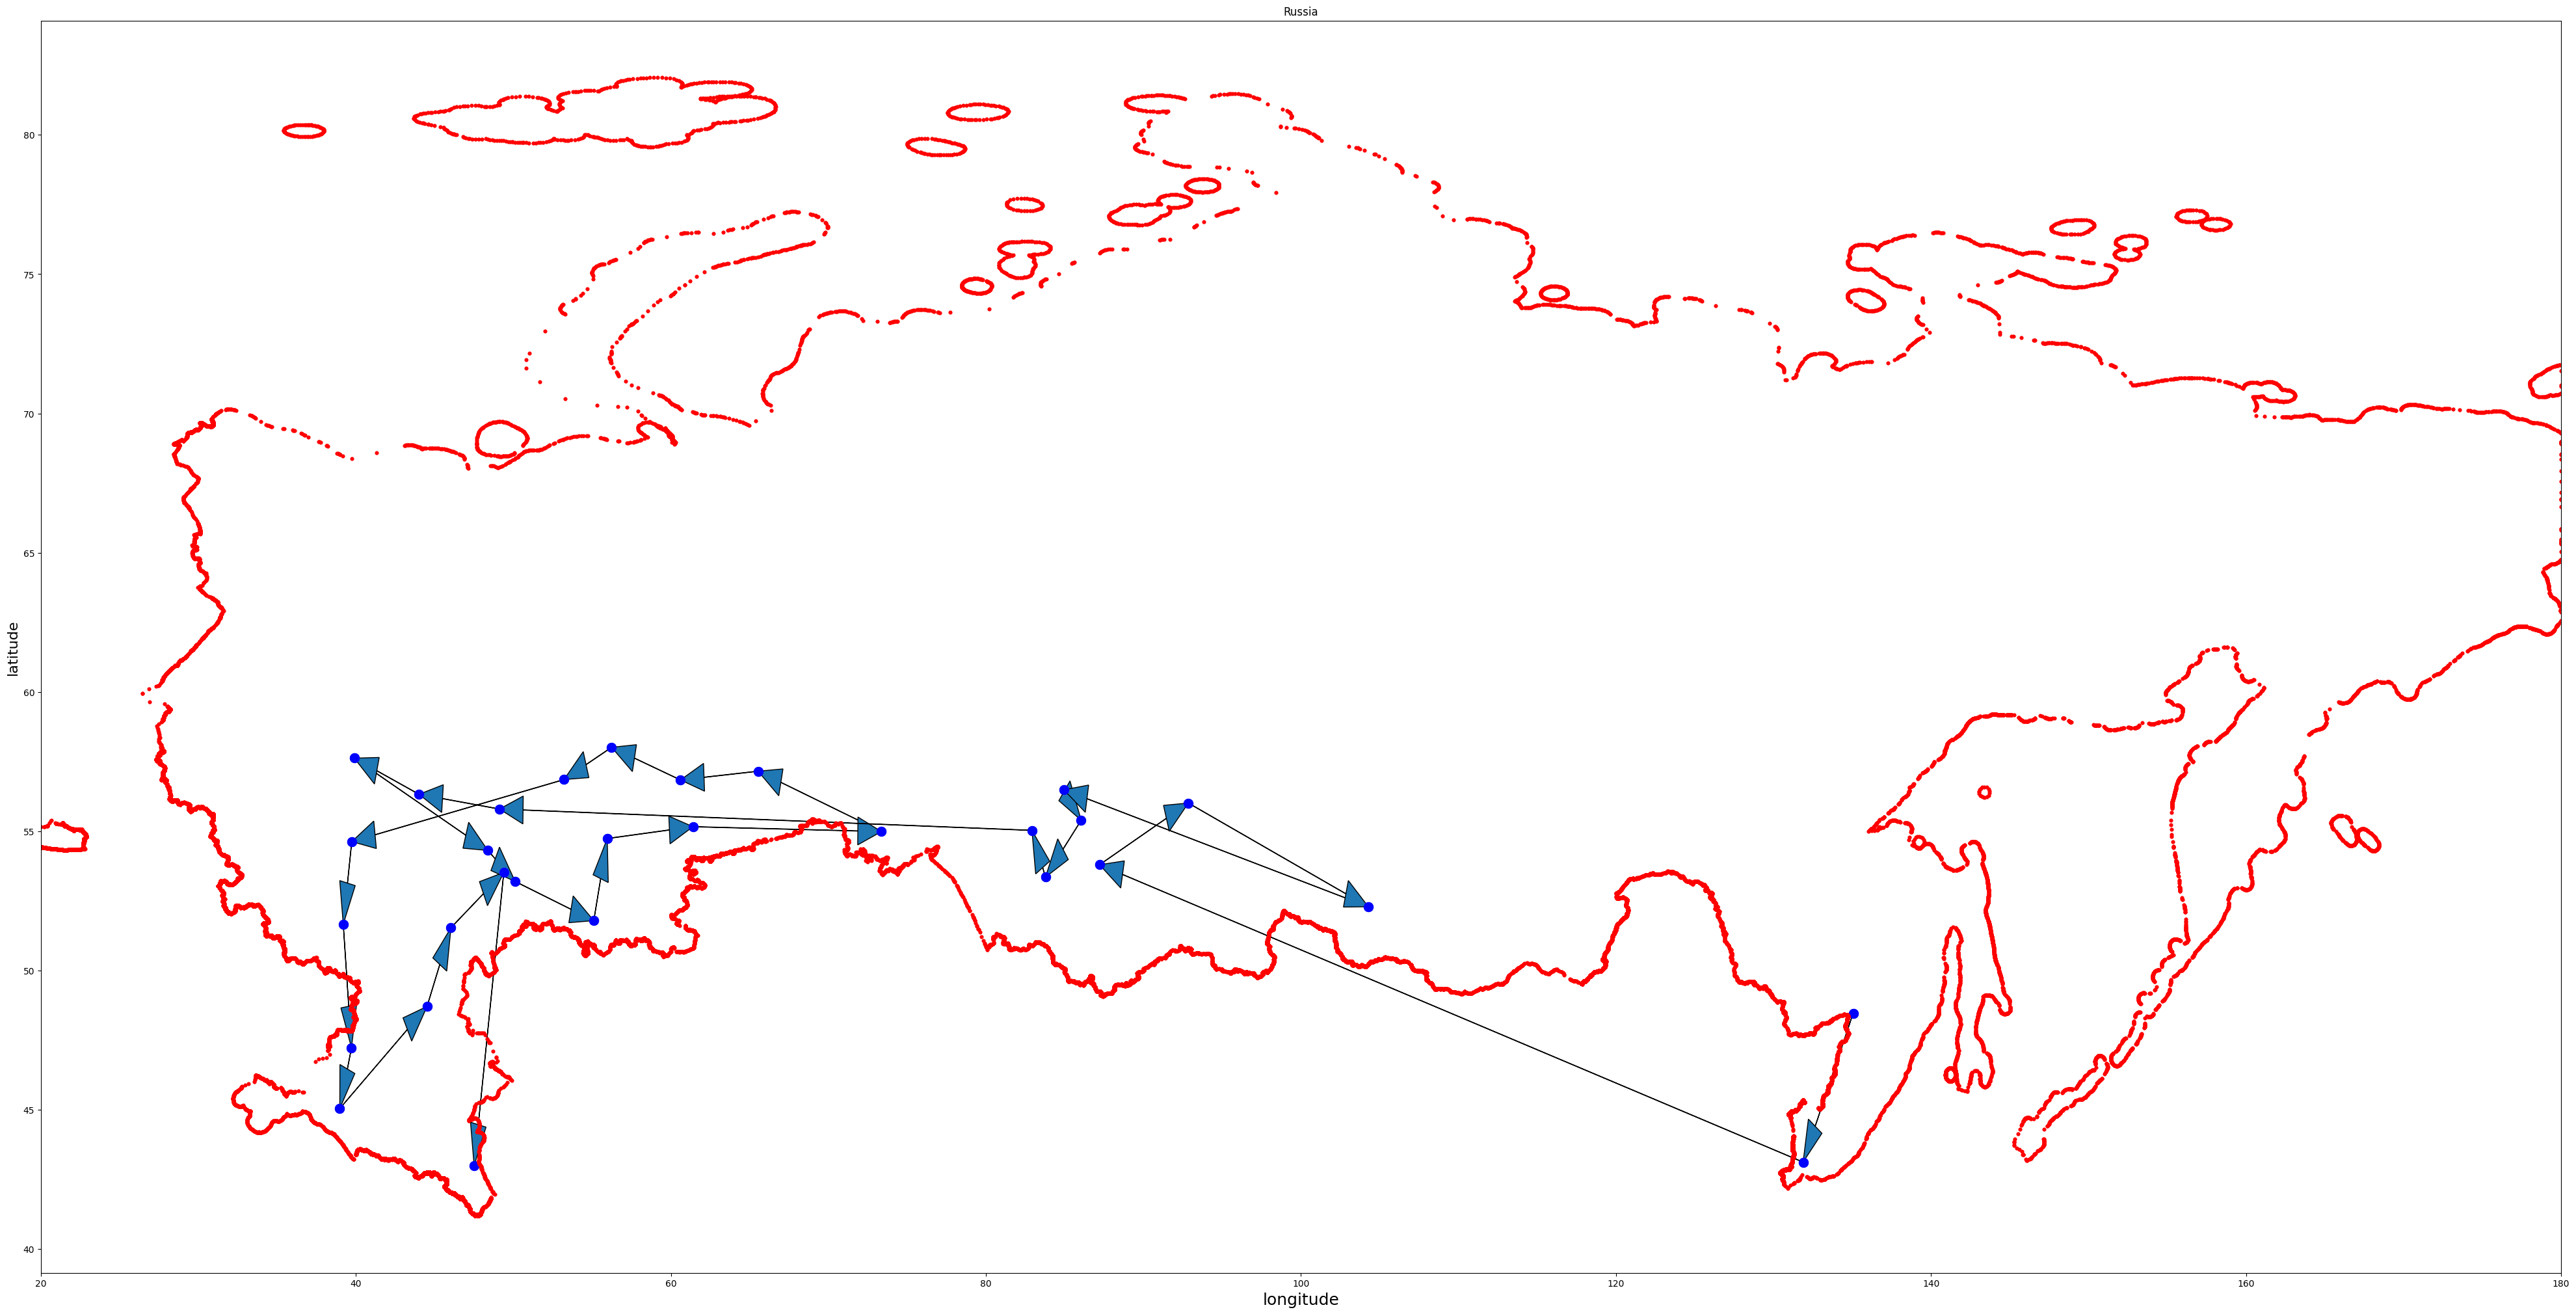

In [6]:
sa = SA(iterations = 1000, temp = 1000, gamma = 0.99, cities=largest_cities.copy().sample(frac=1))
#if you want to see animation in video format and save it
ani = sa.make_animation(interval=10)
ani.save('ani.mp4')
#if you want to just see 'before' and 'after' maps
# sa.plot_map()
# sa.annealing()
# sa.plot_map()

In [13]:
bests = []
gammas = [0.995, 0.99, 0.9, 0.8, 0.7, 0.6, 0.5]
for gamma in gammas:
    sa = SA(temp_limit=10, temp = 1000, gamma = gamma, cities=largest_cities.copy())
    bests.append(sa.annealing())

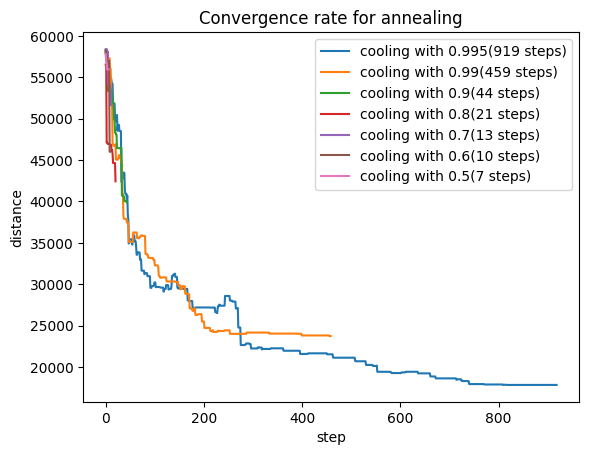

In [14]:
for gamma, best in zip(gammas, bests):
    steps = len(best)
    plt.plot(list(range(steps)), best, label=f'cooling with {gamma}({steps} steps)')

plt.xlabel('step')
plt.ylabel('distance')
plt.title('Convergence rate for annealing')
plt.legend()
plt.show()